In [295]:
import pandas as pd
import umap
import glob
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score, cross_val_predict, LeaveOneOut, KFold
from sklearn.svm import SVC
# from hypopt import GridSearch

from sklearn.preprocessing import OneHotEncoder

from umap import UMAP
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA, FastICA
# import psyplot.project as psy
from sklearn.svm import SVR

from sklearn.decomposition import PCA, KernelPCA

from matplotlib.colors import LogNorm
import math

In [296]:
path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/ScCal-SLi_right"
model_path = glob.glob(f"{path}/*")[0]
ukb_emb_file = f"{model_path}/cadasil_random_embeddings/full_embeddings.csv"
print(ukb_emb_file)

/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/ScCal-SLi_right/name07-54-42_78/cadasil_random_embeddings/full_embeddings.csv


In [297]:
ukb_emb = pd.read_csv(ukb_emb_file, index_col=0)
ukb_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32
ID,,,,,,,,,,,,,,,,,,,,,
rv_BIOMRI_CADA_001_010_RG_S3_3DT1_mprage_1iso_ipat2,-15.741159,31.976582,-76.209380,132.455000,13.502833,-15.035481,26.796660,-10.820212,-19.518322,-47.348087,...,28.454443,27.329315,-23.517100,-16.227634,28.623854,-46.016594,-14.148274,16.159557,-41.162400,-25.375286
rv_BIOMRI_CADA_001_011_BK_S3_3DT1_mprage_1iso_ipat2,7.032745,44.623750,-33.889828,71.731930,31.988590,-16.937115,-26.548700,7.197096,18.731678,-10.416293,...,36.534985,20.136866,-22.633043,-14.572310,-30.081367,21.420301,-42.622260,18.037113,36.734627,-8.343766
rv_BIOMRI_CADA_001_012_TE_2_S5_3DT1_mprage_1iso_ipat2,0.667809,15.951781,-12.976472,79.010010,27.798208,29.916710,-18.878748,-33.241623,-1.116767,-63.663150,...,-26.393480,-36.375076,3.522615,19.221169,-48.765915,31.442728,-5.095129,-32.760624,63.032776,11.338992
rv_BIOMRI_CADA_001_012_TE_S3_3DT1_mprage_1iso_ipat2,-11.804127,23.806545,-4.818307,58.885174,27.051958,23.346548,-19.869947,-23.376800,-4.153165,-62.077156,...,-5.226627,-35.057137,9.791383,6.708715,-46.131850,19.293306,1.300398,-18.755669,53.912067,14.241803
rv_BIOMRI_CADA_001_014_LV_S3_3DT1_mprage_1iso_ipat2,11.776239,7.066210,-40.515583,-37.377370,-22.413689,30.016283,-12.600651,30.099874,16.732134,-1.845092,...,-2.350255,-29.605831,47.377033,-28.498846,-46.385883,36.686466,3.634396,3.986848,-6.338018,-1.508927
rv_BIOMRI_CADA_001_017_LE_S3_3DT1_mprage_1iso_ipat2,-2.904176,37.790520,-49.624626,108.826900,28.329775,26.048630,-22.469835,-33.090183,9.786113,-71.786250,...,14.685707,-6.807463,-48.765938,23.642927,-37.704124,16.216990,-36.862408,-11.882260,61.816727,17.444784
rv_BIOMRI_CADA_001_019_JM_S3_3DT1_mprage_1iso_ipat2,-33.794857,28.020107,-2.529019,131.222000,54.275196,-45.264915,4.067056,9.268724,-5.228845,-23.377980,...,21.646317,-5.386807,-26.683613,-55.777763,-29.368410,-11.005614,-65.305730,-19.544521,38.996260,20.888285
rv_BIOMRI_CADA_001_020_FJ_2_S3_3DT1_mprage_1iso_ipat2,-33.383470,-11.896018,46.076740,150.559200,31.214281,-24.100204,4.769296,-20.594550,-19.992163,-0.552585,...,8.533012,22.208914,7.028171,-26.200941,-56.174908,13.590075,-32.819720,-8.546361,49.246500,-14.641253
rv_BIOMRI_CADA_001_020_FJ_S3_3DT1_mprage_1iso_ipat2,-17.814260,-1.839838,21.876291,98.814170,18.496685,7.832155,0.310068,-17.201672,-29.229680,-8.921210,...,-7.550926,17.064125,31.244545,6.722527,-56.757110,48.491560,-15.824576,-7.322143,31.357204,-30.536615


# cadasil

In [298]:
# norm = ukb_emb.apply(np.linalg.norm, axis=1)
# ukb_emb = ukb_emb.div(norm, axis=0)

In [299]:
ukb_emb

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32
ID,,,,,,,,,,,,,,,,,,,,,
rv_BIOMRI_CADA_001_010_RG_S3_3DT1_mprage_1iso_ipat2,-15.741159,31.976582,-76.209380,132.455000,13.502833,-15.035481,26.796660,-10.820212,-19.518322,-47.348087,...,28.454443,27.329315,-23.517100,-16.227634,28.623854,-46.016594,-14.148274,16.159557,-41.162400,-25.375286
rv_BIOMRI_CADA_001_011_BK_S3_3DT1_mprage_1iso_ipat2,7.032745,44.623750,-33.889828,71.731930,31.988590,-16.937115,-26.548700,7.197096,18.731678,-10.416293,...,36.534985,20.136866,-22.633043,-14.572310,-30.081367,21.420301,-42.622260,18.037113,36.734627,-8.343766
rv_BIOMRI_CADA_001_012_TE_2_S5_3DT1_mprage_1iso_ipat2,0.667809,15.951781,-12.976472,79.010010,27.798208,29.916710,-18.878748,-33.241623,-1.116767,-63.663150,...,-26.393480,-36.375076,3.522615,19.221169,-48.765915,31.442728,-5.095129,-32.760624,63.032776,11.338992
rv_BIOMRI_CADA_001_012_TE_S3_3DT1_mprage_1iso_ipat2,-11.804127,23.806545,-4.818307,58.885174,27.051958,23.346548,-19.869947,-23.376800,-4.153165,-62.077156,...,-5.226627,-35.057137,9.791383,6.708715,-46.131850,19.293306,1.300398,-18.755669,53.912067,14.241803
rv_BIOMRI_CADA_001_014_LV_S3_3DT1_mprage_1iso_ipat2,11.776239,7.066210,-40.515583,-37.377370,-22.413689,30.016283,-12.600651,30.099874,16.732134,-1.845092,...,-2.350255,-29.605831,47.377033,-28.498846,-46.385883,36.686466,3.634396,3.986848,-6.338018,-1.508927
rv_BIOMRI_CADA_001_017_LE_S3_3DT1_mprage_1iso_ipat2,-2.904176,37.790520,-49.624626,108.826900,28.329775,26.048630,-22.469835,-33.090183,9.786113,-71.786250,...,14.685707,-6.807463,-48.765938,23.642927,-37.704124,16.216990,-36.862408,-11.882260,61.816727,17.444784
rv_BIOMRI_CADA_001_019_JM_S3_3DT1_mprage_1iso_ipat2,-33.794857,28.020107,-2.529019,131.222000,54.275196,-45.264915,4.067056,9.268724,-5.228845,-23.377980,...,21.646317,-5.386807,-26.683613,-55.777763,-29.368410,-11.005614,-65.305730,-19.544521,38.996260,20.888285
rv_BIOMRI_CADA_001_020_FJ_2_S3_3DT1_mprage_1iso_ipat2,-33.383470,-11.896018,46.076740,150.559200,31.214281,-24.100204,4.769296,-20.594550,-19.992163,-0.552585,...,8.533012,22.208914,7.028171,-26.200941,-56.174908,13.590075,-32.819720,-8.546361,49.246500,-14.641253
rv_BIOMRI_CADA_001_020_FJ_S3_3DT1_mprage_1iso_ipat2,-17.814260,-1.839838,21.876291,98.814170,18.496685,7.832155,0.310068,-17.201672,-29.229680,-8.921210,...,-7.550926,17.064125,31.244545,6.722527,-56.757110,48.491560,-15.824576,-7.322143,31.357204,-30.536615


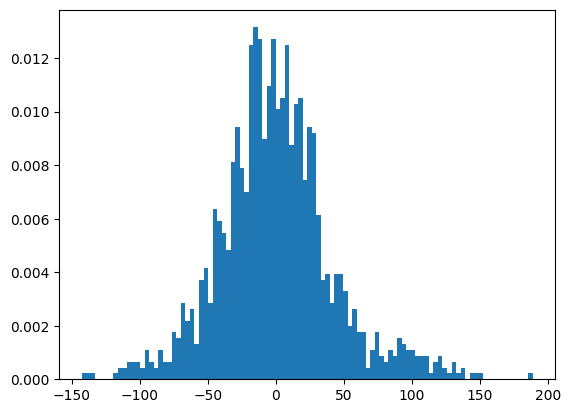

In [300]:
p = plt.hist(ukb_emb.values.ravel(), bins=100, density=True)

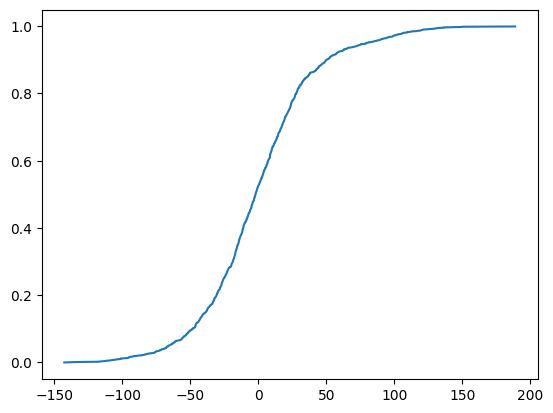

In [301]:
Z = ukb_emb.values.ravel()
N = len(Z)
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

plt.plot(X2, F2)

In [302]:
X2[int(N*0.59)]

6.2920094

In [303]:
len(ukb_emb)

43

In [304]:
ukb_positive = (ukb_emb>0).sum(axis=0)/len(ukb_emb)
ukb_positive = ukb_positive.sort_values(ascending=False)

In [305]:
ukb_positive

dim16    1.000000
dim17    0.976744
dim4     0.953488
dim15    0.883721
dim31    0.883721
dim28    0.860465
dim5     0.767442
dim23    0.744186
dim11    0.674419
dim24    0.627907
dim6     0.558140
dim19    0.511628
dim2     0.511628
dim7     0.488372
dim13    0.418605
dim25    0.395349
dim1     0.372093
dim20    0.372093
dim21    0.348837
dim26    0.348837
dim32    0.325581
dim8     0.325581
dim30    0.325581
dim9     0.255814
dim18    0.255814
dim3     0.232558
dim22    0.209302
dim10    0.162791
dim29    0.139535
dim27    0.116279
dim14    0.069767
dim12    0.000000
dtype: float64

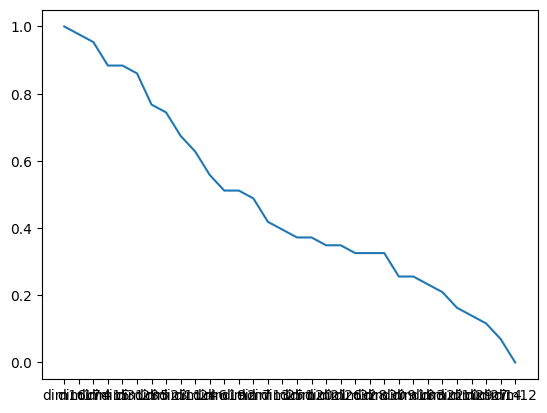

In [306]:
plt.plot(ukb_positive)

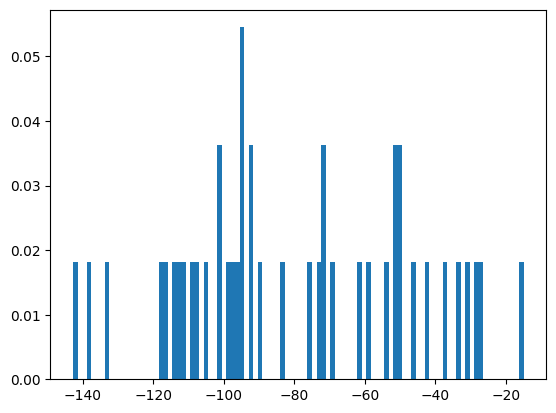

In [307]:
p = plt.hist(ukb_emb.loc[:,"dim12"], bins=100, density=True)

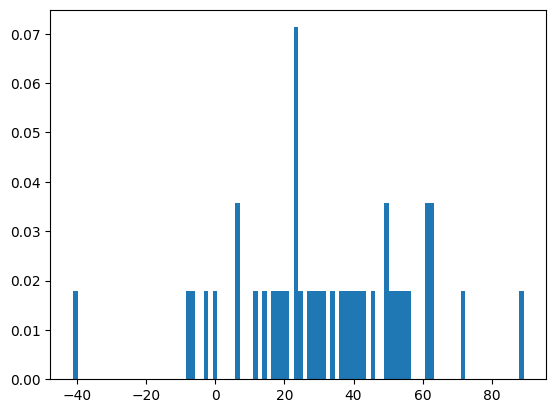

In [308]:
p = plt.hist(ukb_emb.loc[:,"dim31"], bins=100, density=True)

# UMAP

In [309]:
def compute_umap(df, n_neighbors=15, n_components=2):
    # apply umap
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [310]:
visual_ukb_emb, reducer = compute_umap(ukb_emb, n_neighbors=5)

/neurospin/dico/jchavas/Runs/82_V1_after_ablation/Program/venv_rosette/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


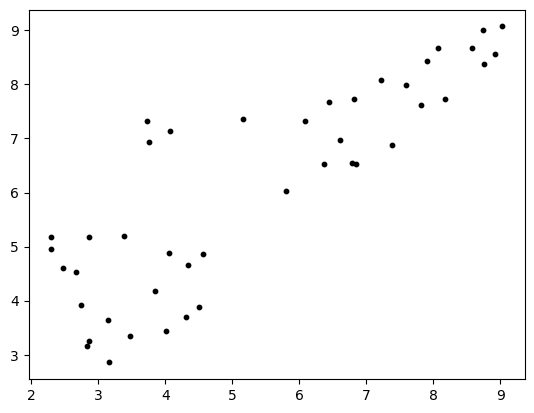

In [311]:
plt.scatter(visual_ukb_emb[:,0], visual_ukb_emb[:,1], c='black', s=10, alpha=1)

In [312]:
ukb_emb.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32
ID,,,,,,,,,,,,,,,,,,,,,
rv_BIOMRI_CADA_001_010_RG_S3_3DT1_mprage_1iso_ipat2,-15.741159,31.976582,-76.209380,132.455000,13.502833,-15.035481,26.796660,-10.820212,-19.518322,-47.348087,...,28.454443,27.329315,-23.517100,-16.227634,28.623854,-46.016594,-14.148274,16.159557,-41.162400,-25.375286
rv_BIOMRI_CADA_001_011_BK_S3_3DT1_mprage_1iso_ipat2,7.032745,44.623750,-33.889828,71.731930,31.988590,-16.937115,-26.548700,7.197096,18.731678,-10.416293,...,36.534985,20.136866,-22.633043,-14.572310,-30.081367,21.420301,-42.622260,18.037113,36.734627,-8.343766
rv_BIOMRI_CADA_001_012_TE_2_S5_3DT1_mprage_1iso_ipat2,0.667809,15.951781,-12.976472,79.010010,27.798208,29.916710,-18.878748,-33.241623,-1.116767,-63.663150,...,-26.393480,-36.375076,3.522615,19.221169,-48.765915,31.442728,-5.095129,-32.760624,63.032776,11.338992
rv_BIOMRI_CADA_001_012_TE_S3_3DT1_mprage_1iso_ipat2,-11.804127,23.806545,-4.818307,58.885174,27.051958,23.346548,-19.869947,-23.376800,-4.153165,-62.077156,...,-5.226627,-35.057137,9.791383,6.708715,-46.131850,19.293306,1.300398,-18.755669,53.912067,14.241803
rv_BIOMRI_CADA_001_014_LV_S3_3DT1_mprage_1iso_ipat2,11.776239,7.066210,-40.515583,-37.377370,-22.413689,30.016283,-12.600651,30.099874,16.732134,-1.845092,...,-2.350255,-29.605831,47.377033,-28.498846,-46.385883,36.686466,3.634396,3.986848,-6.338018,-1.508927


In [313]:
reduced_ukb_emb, reducer_red = compute_umap(ukb_emb, n_neighbors=5, n_components=3)

/neurospin/dico/jchavas/Runs/82_V1_after_ablation/Program/venv_rosette/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


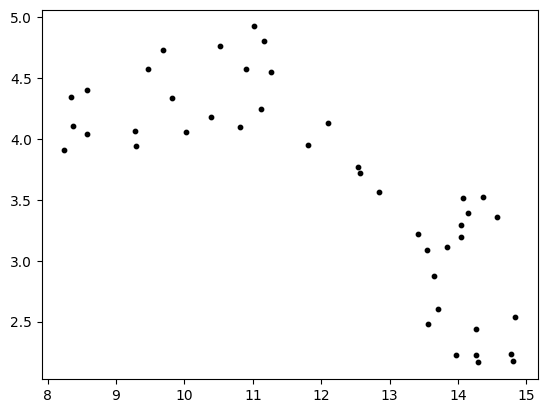

In [314]:
plt.scatter(reduced_ukb_emb[:,0], reduced_ukb_emb[:,1], c='black', s=10, alpha=1)

In [315]:
reduced_ukb_emb.shape

(43, 3)

In [316]:
umap_ukb = visual_ukb_emb

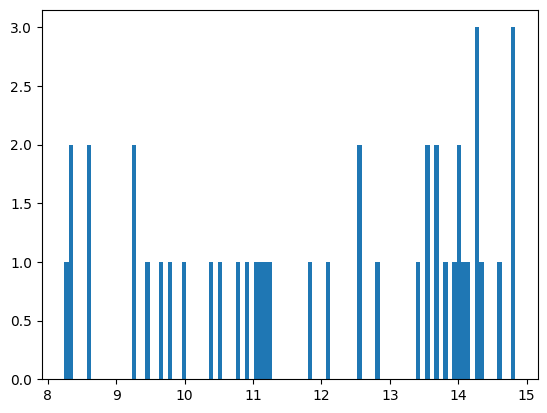

In [317]:
h = plt.hist(reduced_ukb_emb[:,0], bins=100)

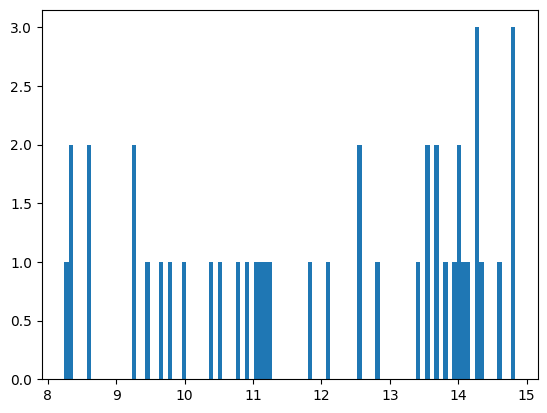

In [318]:
h = plt.hist(reduced_ukb_emb[:,0], bins=100)

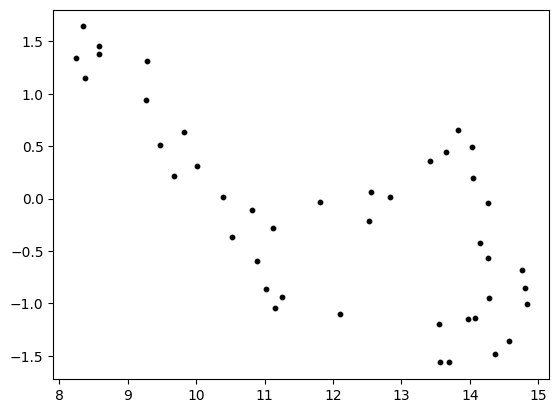

In [319]:
plt.scatter(reduced_ukb_emb[:,0], reduced_ukb_emb[:,2], c='black', s=10, alpha=1)

In [320]:
# plt.scatter(reduced_ukb_emb[:,4], reduced_ukb_emb[:,5], c='black', s=10, alpha=1)

In [321]:
my_model = PCA(n_components=20)
on_axes_PCA = my_model.fit_transform(ukb_emb)
explained_all = my_model.explained_variance_ratio_.cumsum()

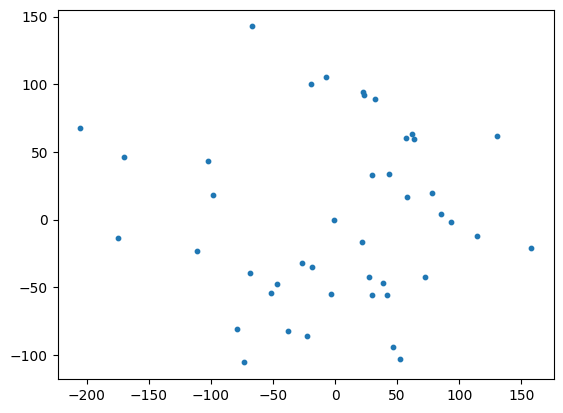

In [322]:
plt.scatter(on_axes_PCA[:,0], on_axes_PCA[:,1], s=10)

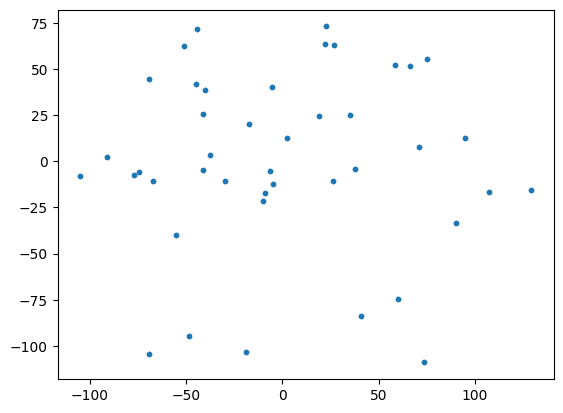

In [323]:
plt.scatter(on_axes_PCA[:,2], on_axes_PCA[:,3], s=10)

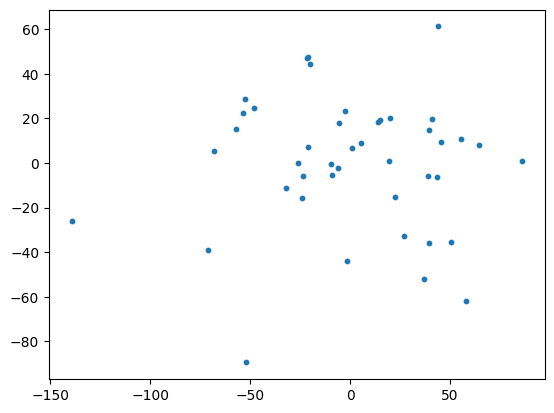

In [324]:
plt.scatter(on_axes_PCA[:,4], on_axes_PCA[:,5], s=10)

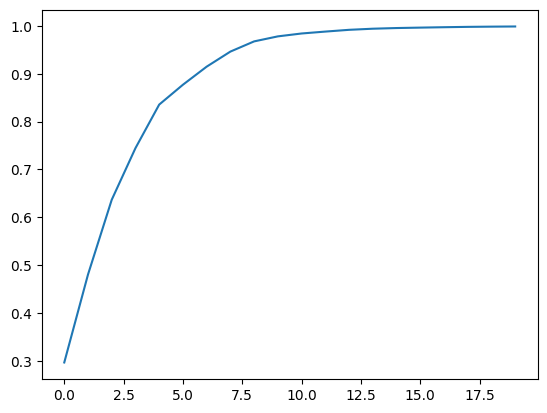

In [325]:
plt.plot(explained_all)
plt.show()

In [326]:
reduced_ukb_emb.shape

(43, 3)

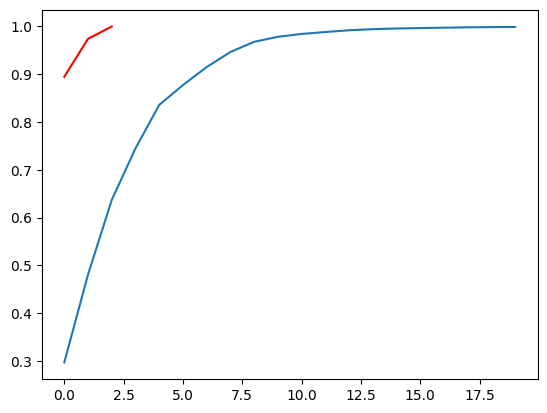

In [327]:
my_model = PCA(n_components=3)
on_axes = my_model.fit_transform(reduced_ukb_emb)
explained = my_model.explained_variance_ratio_.cumsum()
plt.plot(explained, 'r')
plt.plot(explained_all)
plt.show()

In [328]:
explained

array([0.8947245, 0.9741279, 1.       ], dtype=float32)

In [329]:
explained_all

array([0.2964661 , 0.4803643 , 0.63670526, 0.74468511, 0.8357272 ,
       0.87724903, 0.91502114, 0.94654245, 0.96786918, 0.97835976,
       0.98439031, 0.98837193, 0.99205536, 0.99437263, 0.9957791 ,
       0.99667514, 0.99750831, 0.99823963, 0.99870608, 0.99904948])

In [330]:
on_axes.shape

(43, 3)

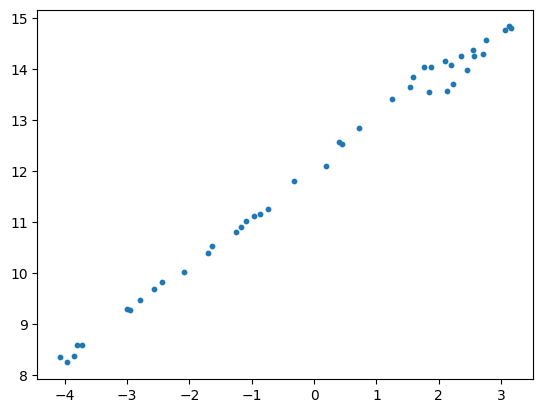

In [331]:
plt.scatter(on_axes[:,0], reduced_ukb_emb[:,0], s=10)

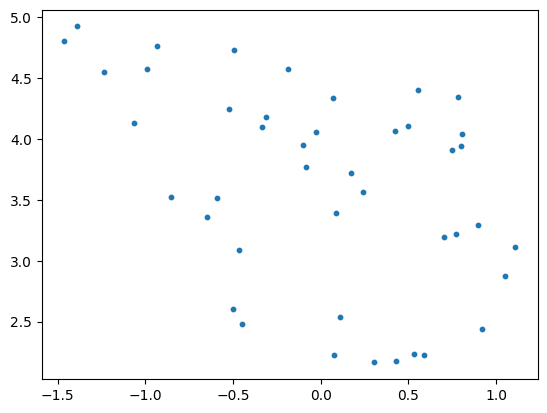

In [332]:
plt.scatter(on_axes[:,1], reduced_ukb_emb[:,1], s=10)

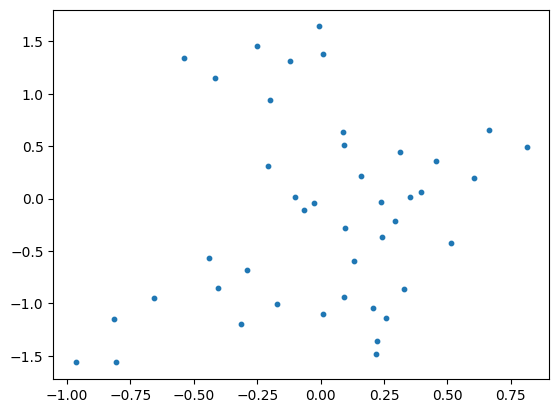

In [333]:
plt.scatter(on_axes[:,2], reduced_ukb_emb[:,2], s=10)

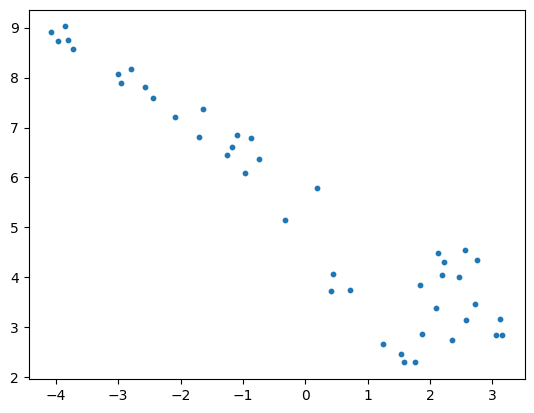

In [334]:
plt.scatter(on_axes[:,0], visual_ukb_emb[:,0], s=10)

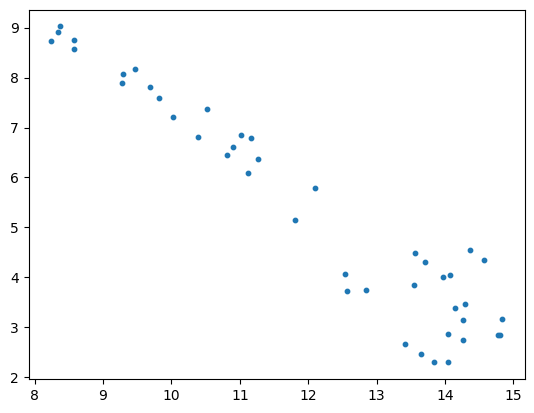

In [335]:
plt.scatter(reduced_ukb_emb[:,0], visual_ukb_emb[:,0], s=10)

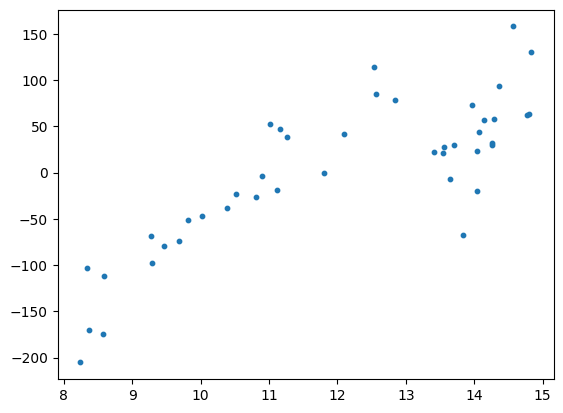

In [336]:
plt.scatter(reduced_ukb_emb[:,0], on_axes_PCA[:,0], s=10)

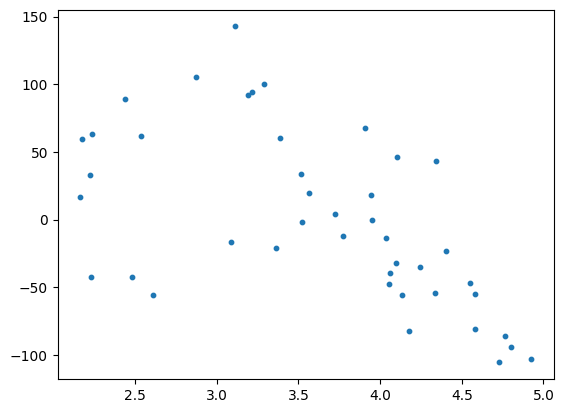

In [337]:
plt.scatter(reduced_ukb_emb[:,1], on_axes_PCA[:,1], s=10)

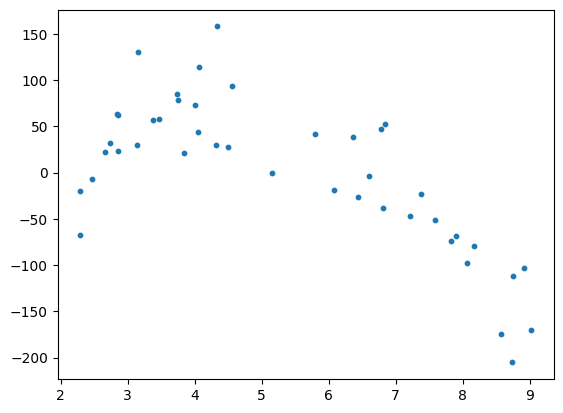

In [338]:
plt.scatter(visual_ukb_emb[:,0], on_axes_PCA[:,0], s=10)

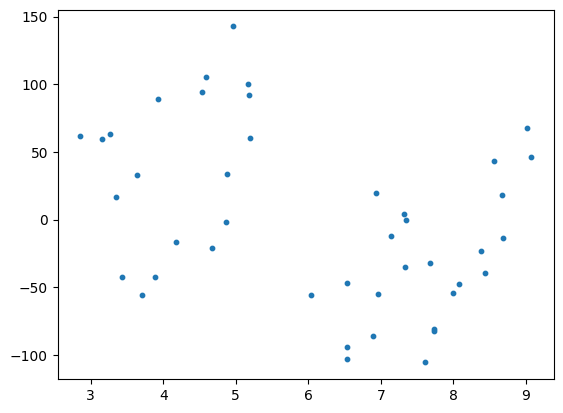

In [339]:
plt.scatter(visual_ukb_emb[:,1], on_axes_PCA[:,1], s=10)

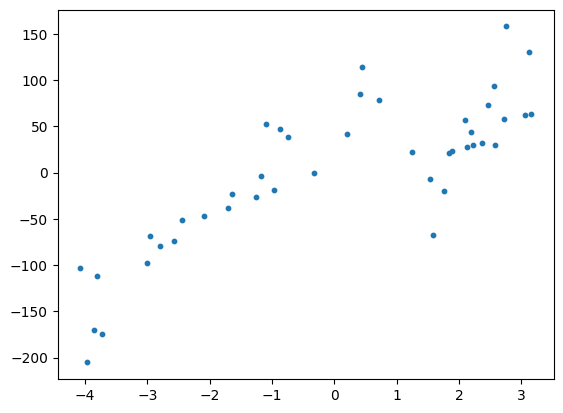

In [340]:
plt.scatter(on_axes[:,0], on_axes_PCA[:,0], s=10)

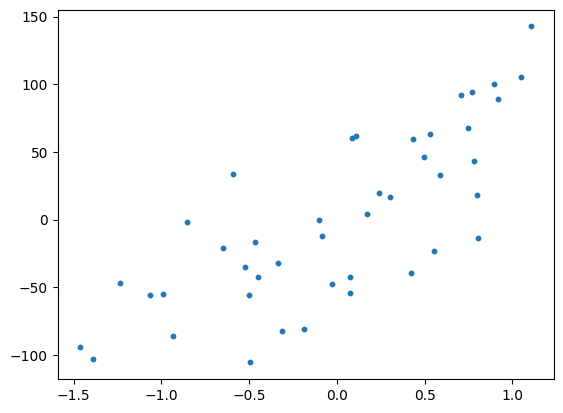

In [341]:
plt.scatter(on_axes[:,1], on_axes_PCA[:,1], s=10)

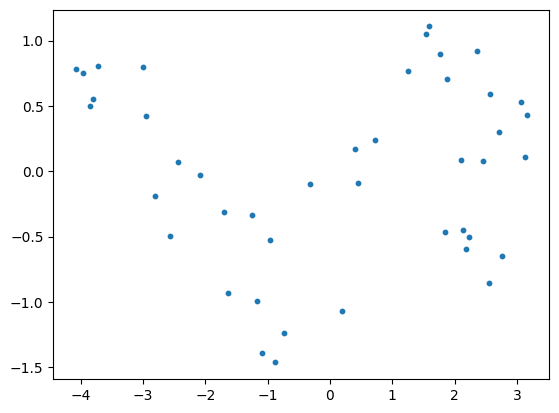

In [342]:
plt.scatter(on_axes[:,0], on_axes[:,1], s=10)

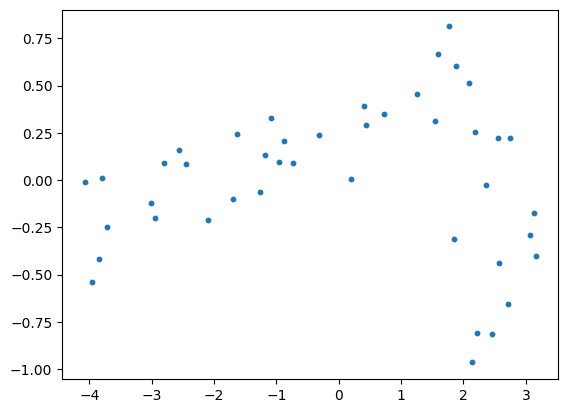

In [343]:
plt.scatter(on_axes[:,0], on_axes[:,2], s=10)
plt.show()

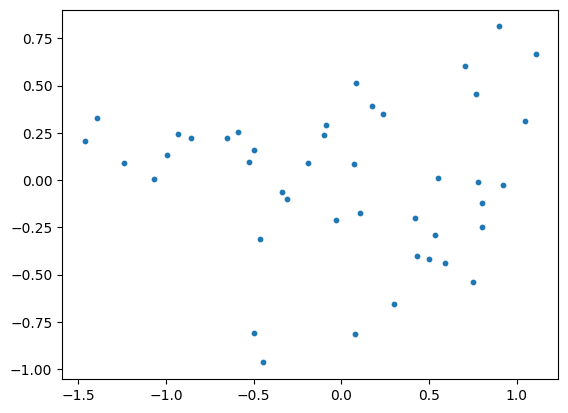

In [344]:
plt.scatter(on_axes[:,1], on_axes[:,2], s=10)
plt.show()

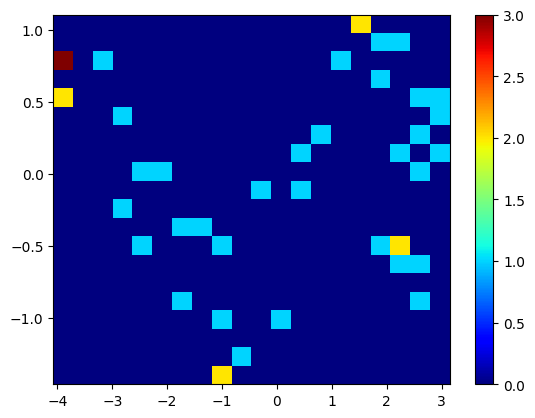

In [345]:
heatmap, xedges, yedges = np.histogram2d(on_axes[:,0], on_axes[:,1], bins=(20,20))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower', extent=extent, aspect='auto', cmap=cm.jet)
# plt.figure(figsize=(8,100))
plt.colorbar()
plt.show()